In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as mcolors
import seaborn as sns
import math

# import warnings
# warnings.filterwarnings('ignore')

from datetime import timedelta

In [13]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils

# Load FastF1's dark color scheme
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [14]:
# Enable the cache by providing the name of your cache folder
cache_path = '/Users/charlotte/Desktop/mclaren-performance-analysis-2024/cache'
ff1.Cache.enable_cache(cache_path)

In [15]:
# Define target session
year, grand_prix, session = 2024, 'Mexico', 'Q'

# Load target session
target_session = ff1.get_session(year, grand_prix, session)
target_session.load(telemetry=True)

# Define target drivers
driver_1, driver_2 = 'NOR', 'VER'
team_1, team_2, team_3 = 'McLaren', 'Ferrari', 'Red Bull Racing'

core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.4.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            I

In [16]:
# Function to lighten team colour
def lighten_color(color, amount=0.5):
    color = mcolors.to_rgb(color)
    return [(1 - amount) * c + amount for c in color]

# Retrieve team colors from target_session.results based on driver abbreviations
team_color_1 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_1].iloc[0]['TeamColor']
team_color_2 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_2].iloc[0]['TeamColor']

# If drivers for analysis are from the same team then adjust driver_2 colour
if team_color_1 == team_color_2:
    # Lighten one color for distinction or use a dashed line
    from matplotlib.colors import to_rgb
    team_color_2 = lighten_color(team_color_2, amount=0.6)
    linestyle_2 = '--'

In [17]:
telemetry = target_session.laps.loc[0].get_car_data().add_distance()
telemetry.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-10-26 21:01:28.669,3618,30,1,0,False,8,car,0 days 00:00:00.223000,0 days 00:13:56.905000,1.858333
1,2024-10-26 21:01:28.909,3729,30,1,0,False,8,car,0 days 00:00:00.463000,0 days 00:13:57.145000,3.858333
2,2024-10-26 21:01:29.269,3579,31,1,0,False,8,car,0 days 00:00:00.823000,0 days 00:13:57.505000,6.958333
3,2024-10-26 21:01:29.669,3452,31,1,0,False,8,car,0 days 00:00:01.223000,0 days 00:13:57.905000,10.402778
4,2024-10-26 21:01:29.869,3604,31,1,0,False,8,car,0 days 00:00:01.423000,0 days 00:13:58.105000,12.125000


In [18]:
# Access selected driver fastest laps
laps_driver_1 = target_session.laps.pick_drivers(driver_1).pick_fastest()
laps_driver_2 = target_session.laps.pick_drivers(driver_2).pick_fastest()

# Retrieve the telemetry and add the distance column
telemetry_driver_1 = laps_driver_1.get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.get_car_data().add_distance()

In [19]:
# Identify session type analysed for title in more legible way
session_types = {
    'Q': 'Qualifying',
    'R': 'Grand Prix',
    'Practice 1': 'FP1',
    'Practice 2': 'FP2',
    'Practice 3': 'FP3'
}

session_type = session_types.get(session, 'Unknown Session')

In [20]:
# Identify the faster lap
fastest_lap_driver_1 = target_session.laps.pick_driver(driver_1).pick_fastest()
fastest_lap_driver_2 = target_session.laps.pick_driver(driver_2).pick_fastest()

# Determine which driver was faster
total_time_1 = fastest_lap_driver_1['LapTime']
total_time_2 = fastest_lap_driver_2['LapTime']
if total_time_1 < total_time_2:
    ref_driver = driver_1
    ref_lap = fastest_lap_driver_1
    compare_driver = driver_2
    compare_lap = fastest_lap_driver_2
    delta_line_color = team_color_2
    base_line_color = team_color_1
else:
    ref_driver = driver_2
    ref_lap = fastest_lap_driver_2
    compare_driver = driver_1
    compare_lap = fastest_lap_driver_1
    delta_line_color = team_color_1
    base_line_color = team_color_2
    

# Extract delta time between the drivers using the fastest laps
delta_time, ref_tel, compare_tel = utils.delta_time(ref_lap, compare_lap)
delta_time_seconds = delta_time.astype(float)   # Directly use delta_time if it's already in seconds

# Calculate 20% margin for y-axis limits based on the maximum delta value
max_delta = max(abs(delta_time))
y_limit = max_delta * 1.2  # 20% extra

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/utils.py:89: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/plotting/_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


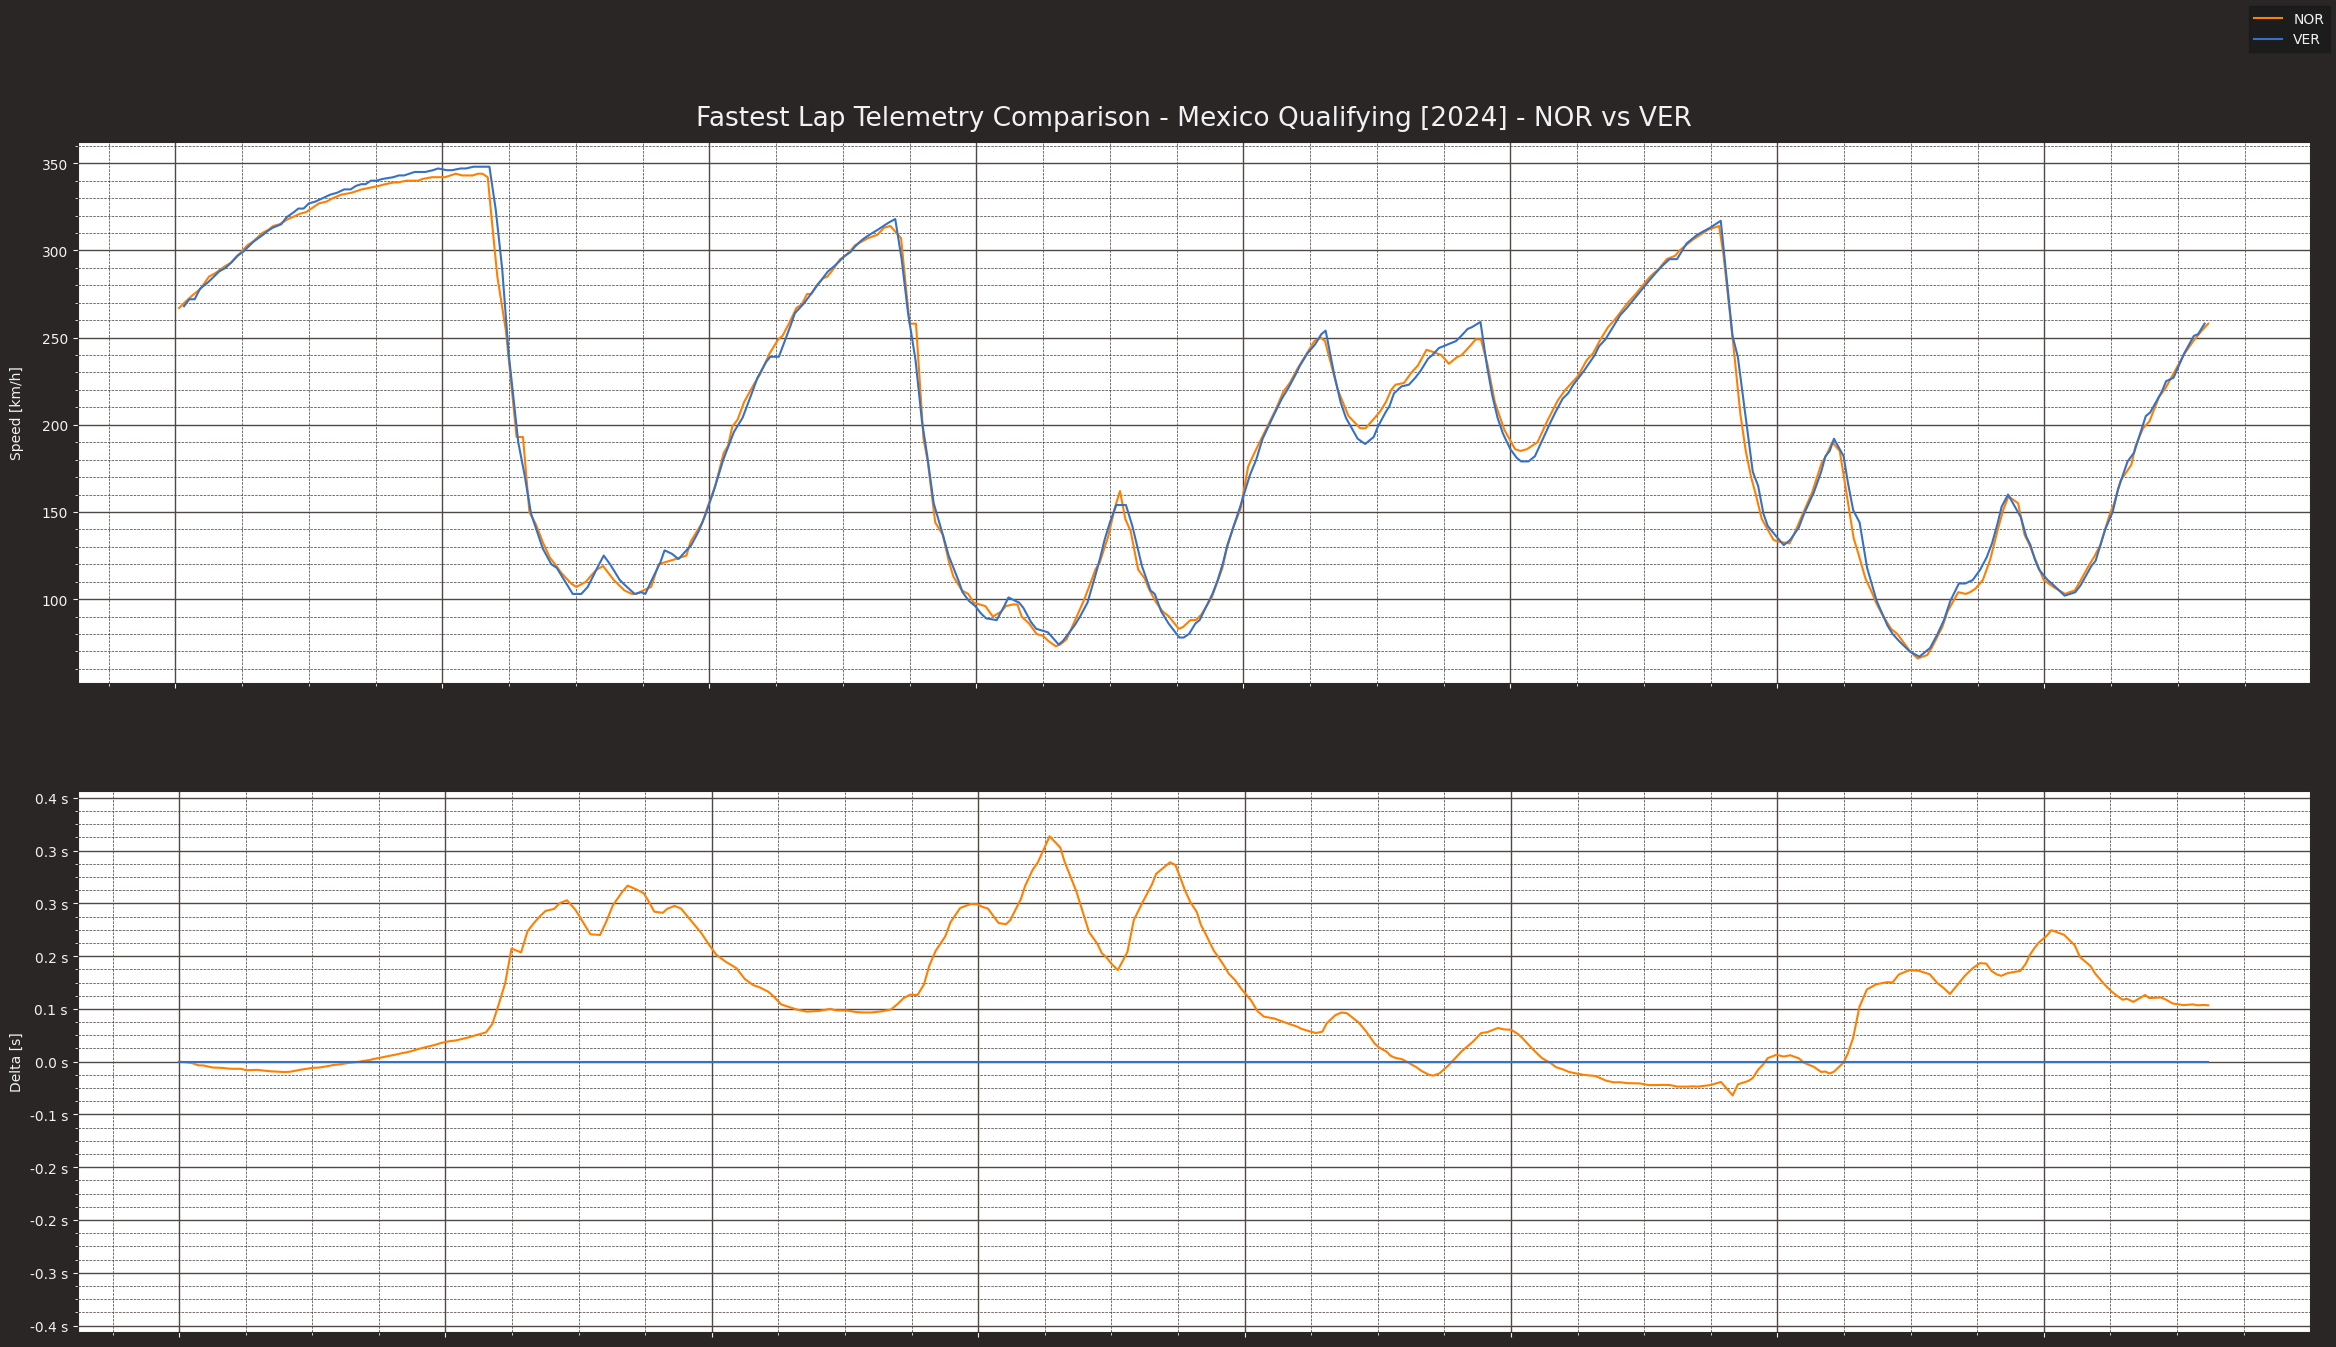

In [21]:
# Plot Telemetry
plotting.setup_mpl(color_scheme='fastf1')

subplots_number = 2 # Adjust to match number of plots included
fig, ax = plt.subplots(subplots_number,figsize=(24,14))

background = "white"
title_color = 'silver' # '#6441a5'

ax[0].set_facecolor(background)
# ax[1].set_facecolor(background)
# ax[2].set_facecolor(background)
# ax[3].set_facecolor(background)
# ax[4].set_facecolor(background)
# ax[5].set_facecolor(background)
ax[1].set_facecolor(background)


ax[0].plot(telemetry_driver_1['Time'], telemetry_driver_1['Speed'], color=team_color_1, linestyle='-', label=driver_1)
ax[0].plot(telemetry_driver_2['Time'], telemetry_driver_2['Speed'], color=team_color_2, linestyle='-', label=driver_2)

# ax[1].plot(telemetry_driver_1['Time'], telemetry_driver_1['RPM'], color=team_color_1, linestyle='-', label=driver_1)
# ax[1].plot(telemetry_driver_2['Time'], telemetry_driver_2['RPM'], color=team_color_2, linestyle='-', label=driver_2)

# ax[2].plot(telemetry_driver_1['Time'], telemetry_driver_1['nGear'], color=team_color_1, linestyle='-', label=driver_1)
# ax[2].plot(telemetry_driver_2['Time'], telemetry_driver_2['nGear'], color=team_color_2, linestyle='-', label=driver_2)

# ax[3].plot(telemetry_driver_1['Time'], telemetry_driver_1['Throttle'], color=team_color_1, linestyle='-', label=driver_1)
# ax[3].plot(telemetry_driver_2['Time'], telemetry_driver_2['Throttle'], color=team_color_2, linestyle='-', label=driver_2)

# ax[4].plot(telemetry_driver_1['Time'], telemetry_driver_1['Brake'], color=team_color_1, linestyle='-', label=driver_1)
# ax[4].plot(telemetry_driver_2['Time'], telemetry_driver_2['Brake'], color=team_color_2, linestyle='-', label=driver_2)

# ax[5].plot(telemetry_driver_1['Time'], telemetry_driver_1['DRS'], color=team_color_1, linestyle='-', label=driver_1)
# ax[5].plot(telemetry_driver_2['Time'], telemetry_driver_2['DRS'], color=team_color_2, linestyle='-', label=driver_2)

# Plot Delta Time with centered y-axis in seconds
ax[1].plot(ref_tel['Time'], delta_time_seconds, color=delta_line_color, linestyle='-', label=f"Delta Time ({compare_driver} vs {ref_driver})")
ax[1].plot(ref_tel['Time'], np.zeros_like(ref_tel['Time']), color=base_line_color, linestyle='-', label=f"{ref_driver} (faster)")
ax[1].set_ylim(-y_limit, y_limit)  # Center y-axis around 0 with 20% margin
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f} s"))

ax[0].set_ylabel("Speed [km/h]")
# ax[1].set_ylabel("RPM [#]")
# ax[2].set_ylabel("Gear [#]")
# ax[3].set_ylabel("Throttle [%]")
# ax[4].set_ylabel("Brake [%]")
# ax[5].set_ylabel("DRS")
ax[1].set_ylabel("Delta [s]")

ax[0].get_xaxis().set_ticklabels([])
# ax[1].get_xaxis().set_ticklabels([])
# ax[2].get_xaxis().set_ticklabels([])
# ax[3].get_xaxis().set_ticklabels([])
# ax[4].get_xaxis().set_ticklabels([])
# ax[5].get_xaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])

fig.align_ylabels()

fig.legend([driver_1,driver_2])


plot_title = 'Fastest Lap Telemetry Comparison - '+grand_prix+' '+session_type+' ['+str(year)+'] - '+driver_1+' vs '+driver_2
ax[0].title.set_text(plot_title)
plt.subplots_adjust(left=0.06 ,right=0.99, top=0.9, bottom=0.05)

# UPDATE - save plot
file_name = '/Users/charlotte/Desktop/'+driver_1+'-vs-'+driver_2+'_'+grand_prix+'_'+session_type+'_driver-telemetry-comparison.png'
plt.savefig(file_name, dpi=300)  # bbox_inches='tight'